## EEG Feature Extraction Notebook

This notebook implements several feature extraction techniques to process EEG data for BCI-based motor imagery classification. The dataset includes right-hand and right-foot imagery data, and we evaluate statistical, time-domain, frequency-domain, Hjorth, and entropy-based features.

### Key Steps:
- Load and filter raw EEG data
- Segment into 1-second windows
- Extract meaningful features per channel
- Output for downstream classification 


In [4]:

from scipy.io import loadmat
import numpy as np

# Load .mat file
data = loadmat('bci.mat')
rf = data['rf'][:, :20]   # Right foot, first 20 channels
rh = data['rh'][:, :20]   # Right hand, first 20 channels
fs = 100                  # Sampling rate (Hz)
print('rf shape:', rf.shape, 'rh shape:', rh.shape)



rf shape: (500000, 20) rh shape: (400000, 20)


In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


## Filtering:
The code block below is used to filter the required frequency. The next block is used to create windows.

In [6]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut, highcut, fs, order=7):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)  
    return y

def notch_filter(data, notch_freq, fs, quality_factor=20):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    y = filtfilt(b, a, data, axis=0)  
    return y

fs = 200  

# Apply notch filter to suppress 50 Hz signal (per channel)
filtered_rf = notch_filter(rf, 50, fs)
filtered_rh = notch_filter(rh, 50, fs)

# Apply bandpass filter between 0.5-30 Hz (per channel)
filtered_rf = bandpass_filter(filtered_rf, 0.5, 30, fs)
filtered_rh = bandpass_filter(filtered_rh, 0.5, 30, fs)

print('filtered_rf shape:', filtered_rf.shape, 'filtered_rh shape:', filtered_rh.shape)


filtered_rf shape: (500000, 20) filtered_rh shape: (400000, 20)


In [7]:
def create_windows(arr, win_size=100, step=100):
    n_samples, n_channels = arr.shape
    windows = []
    for start in range(0, n_samples - win_size + 1, step):
        window = arr[start:start+win_size]
        windows.append(window)
    return np.array(windows)

rf_win = create_windows(filtered_rf, win_size=100, step=100)
rh_win = create_windows(filtered_rh, win_size=100, step=100)
print('rf_win shape:', rf_win.shape, 'rh_win shape:', rh_win.shape)


rf_win shape: (5000, 100, 20) rh_win shape: (4000, 100, 20)


In [8]:
rf_labels = np.zeros(len(rf_win))
rh_labels = np.ones(len(rh_win))

X_win = np.concatenate([rf_win, rh_win], axis=0)
y_win = np.concatenate([rf_labels, rh_labels], axis=0)
print('Total windows:', X_win.shape[0])


Total windows: 9000


## Feature extraction
Features are extracted and feature index mapping is established.

In [ ]:
import antropy as ant
import scipy.stats as stats
from scipy.signal import welch
def extract_statistical_features_window(window):
    feats = []
    for ch in range(window.shape[1]):
        sig = window[:, ch]
        feats.extend([
            np.mean(sig),
            np.median(sig),
            np.std(sig),
            np.var(sig),
            stats.skew(sig),
            stats.kurtosis(sig),
            np.ptp(sig)
        ])
    return np.array(feats)

stat_feats = np.array([extract_statistical_features_window(win) for win in X_win])
def extract_time_domain_features_window(window):
    feats = []
    for ch in range(window.shape[1]):
        sig = window[:, ch]
        rms = np.sqrt(np.mean(sig**2))
        zero_crossings = ((sig[:-1] * sig[1:]) < 0).sum()
        autocorrelation = np.correlate(sig, sig, mode='full')[len(sig)-1]
        mean_abs_dev = np.mean(np.abs(sig - np.mean(sig)))
        max_val = np.max(sig)
        min_val = np.min(sig)
        signal_energy = np.sum(sig**2)
        feats.extend([
            rms, zero_crossings, autocorrelation, mean_abs_dev, max_val, min_val, signal_energy
        ])
    return np.array(feats)

time_feats = np.array([extract_time_domain_features_window(win) for win in X_win])
def extract_frequency_domain_features_window(window, fs=100):
    feats = []
    for ch in range(window.shape[1]):
        sig = window[:, ch]
        freqs, psd = welch(sig, fs)
        dominant_freq = freqs[np.argmax(psd)]
        total_power = np.sum(psd)
        band_power = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])
        mean_freq = np.mean(freqs)
        median_freq = np.median(freqs)
        peak_freq = freqs[np.argmax(psd)]
        freq_variance = np.var(freqs)
        feats.extend([
            dominant_freq, total_power, band_power, mean_freq, median_freq, peak_freq, freq_variance
        ])
    return np.array(feats)

freq_feats = np.array([extract_frequency_domain_features_window(win, fs=100) for win in X_win])
def extract_hjorth_window(window):
    def hjorth_params(sig):
        diff1 = np.diff(sig)
        diff2 = np.diff(diff1)
        var_zero = np.var(sig)
        var_d1 = np.var(diff1)
        var_d2 = np.var(diff2)
        activity = var_zero
        mobility = np.sqrt(var_d1 / var_zero) if var_zero > 0 else 0
        complexity = np.sqrt(var_d2 / var_d1) / mobility if var_d1 > 0 and mobility > 0 else 0
        return [activity, mobility, complexity]
    feats = []
    for ch in range(window.shape[1]):
        feats.extend(hjorth_params(window[:, ch]))
    return np.array(feats)

hjorth_feats = np.array([extract_hjorth_window(win) for win in X_win])


def extract_entropy_features_window(window, fs=100):
    feats = []
    for ch in range(window.shape[1]):
        sig = window[:, ch]
        try:
            sample_entropy = ant.sample_entropy(sig)
        except Exception:
            sample_entropy = np.nan
        try:
            spectral_entropy = ant.spectral_entropy(sig, sf=fs, method='welch')
        except Exception:
            spectral_entropy = np.nan
        try:
            perm_entropy = ant.perm_entropy(sig, normalize=True)
        except Exception:
            perm_entropy = np.nan
        try:
            svd_entropy = ant.svd_entropy(sig, order=3, delay=1)
        except Exception:
            svd_entropy = np.nan
        try:
            app_entropy = ant.app_entropy(sig)
        except Exception:
            app_entropy = np.nan
        try:
            lziv_complexity = ant.lziv_complexity(sig)
        except Exception:
            lziv_complexity = np.nan
        feats.extend([
            sample_entropy, spectral_entropy, perm_entropy,
            svd_entropy, app_entropy, lziv_complexity
        ])
    return np.array(feats)

entropy_feats = np.array([extract_entropy_features_window(win, fs=100) for win in X_win])


In [ ]:
# Number of channels used
n_channels = X_win.shape[2]  

# Automatically compute number of features per channel
feats_per_channel_map = {
    'Statistical': stat_feats.shape[1] // n_channels,
    'Time': time_feats.shape[1] // n_channels,
    'Frequency': freq_feats.shape[1] // n_channels,
    'Hjorth': hjorth_feats.shape[1] // n_channels,
    'Entropy': entropy_feats.shape[1] // n_channels,
    'All': (stat_feats.shape[1] + time_feats.shape[1] + freq_feats.shape[1] +
            hjorth_feats.shape[1] + entropy_feats.shape[1]) // n_channels
}


feature_names_per_type = {
    'Statistical': ["Mean", "Median", "STD", "Var", "Skew", "Kurtosis", "Range"],
    'Time': ["RMS", "ZeroCross", "Autocorr", "MAD", "Max", "Min", "Energy"],
    'Frequency': ["DomFreq", "TotPower", "BandPower", "MeanFreq", "MedFreq", "PeakFreq", "FreqVar"],
    'Hjorth': ["Activity", "Mobility", "Complexity"],
    'Entropy': ["SampleEnt", "SpectralEnt", "PermEnt", "SVDEnt", "AppEnt", "LZivComp"]
}


def print_feature_index_mapping(label, feats_per_channel, feature_names):
    print(f"\n--- {label} Feature Index Mapping ---")
    for ch in range(n_channels):
        for i, fname in enumerate(feature_names):
            feat_idx = ch * feats_per_channel + i
            print(f"{feat_idx:3d} → Ch{ch}_{fname}")

# Print mappings
print_feature_index_mapping("Statistical", feats_per_channel_map['Statistical'], feature_names_per_type['Statistical'])
print_feature_index_mapping("Time", feats_per_channel_map['Time'], feature_names_per_type['Time'])
print_feature_index_mapping("Frequency", feats_per_channel_map['Frequency'], feature_names_per_type['Frequency'])
print_feature_index_mapping("Hjorth", feats_per_channel_map['Hjorth'], feature_names_per_type['Hjorth'])
print_feature_index_mapping("Entropy", feats_per_channel_map['Entropy'], feature_names_per_type['Entropy'])

all_feats = np.concatenate(
    [stat_feats, time_feats, freq_feats, hjorth_feats, entropy_feats], axis=1
)
print(all_feats.shape)  # (n_windows, total_features_all_methods)

stack_order = ['Statistical', 'Time', 'Frequency', 'Hjorth', 'Entropy']


all_feature_index_map = {}
offset = 0

for label in stack_order:
    feats_per_channel = feats_per_channel_map[label]
    feature_names = feature_names_per_type[label]
    for ch in range(n_channels):
        for i, fname in enumerate(feature_names):
            global_idx = offset + ch * feats_per_channel + i
            all_feature_index_map[global_idx] = f"{label}_Ch{ch}_{fname}"
    # Update offset for next block
    offset += feats_per_channel * n_channels


print("\n--- Combined all_feats Feature Index Mapping ---")
for idx in sorted(all_feature_index_map):
    print(f"{idx:3d} → {all_feature_index_map[idx]}")


stack_order = ['Statistical', 'Time', 'Frequency', 'Hjorth', 'Entropy']

all_feature_index_map = {}
offset = 0

for label in stack_order:
    feats_per_channel = feats_per_channel_map[label]
    feature_names = feature_names_per_type[label]
    for ch in range(n_channels):
        for i, fname in enumerate(feature_names):
            global_idx = offset + ch * feats_per_channel + i
            all_feature_index_map[global_idx] = f"{label}_Ch{ch}_{fname}"
    # Update offset for next block
    offset += feats_per_channel * n_channels


print("\n--- Combined all_feats Feature Index Mapping ---")
for idx in sorted(all_feature_index_map):
    print(f"{idx:3d} → {all_feature_index_map[idx]}")




Evaluation is performed without feature selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import numpy as np
results = {}

feature_sets_clean = []
for feats in [stat_feats, time_feats, freq_feats, hjorth_feats, entropy_feats, all_feats]:
    feats_clean = np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)
    feature_sets_clean.append(feats_clean)

feature_labels = [
    'Statistical', 'Time', 'Frequency', 'Hjorth', 'Entropy', 'All'
]



results = {}
n_folds = 10

for feats, label in zip(feature_sets_clean, feature_labels):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    accs = []

    print(f'\n--- {label} features (No Feature Selection) ---')
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(feats, y_win), 1):
        X_train, X_test = feats[train_idx], feats[test_idx]
        y_train, y_test = y_win[train_idx], y_win[test_idx]

        clf = SVC(kernel='rbf')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
        
        print(f'Fold {fold} Accuracy: {acc:.4f}')
    
    mean_acc = np.mean(accs)
    results[label] = mean_acc
    print(f'Mean Accuracy (10-Fold CV): {mean_acc:.4f}')


Classification Accuracy (Without Feature Selection):
Feature Extraction Method  Accuracy (%)
              Statistical         73.81
                     Time         73.30
                Frequency         80.57
                   Hjorth         73.69
                  Entropy         92.57
                      All         73.30


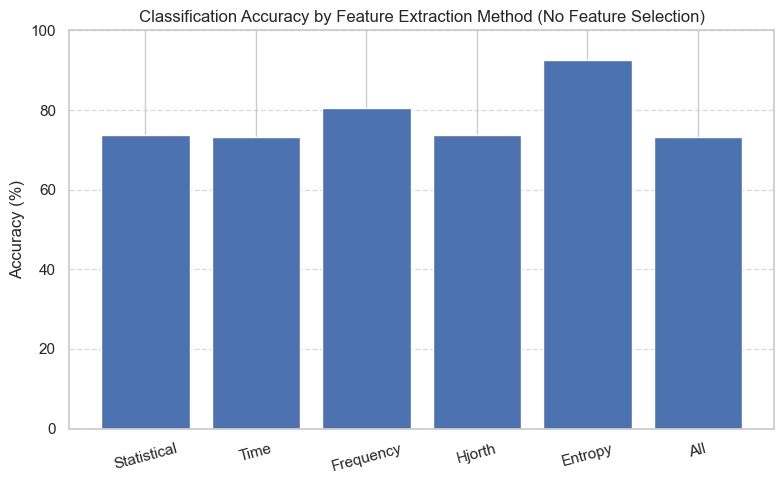

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a DataFrame for the results
acc_table = pd.DataFrame({
    "Feature Extraction Method": list(results.keys()),
    "Accuracy (%)": [round(v * 100, 2) for v in results.values()]
})

# Print the table
print("Classification Accuracy (Without Feature Selection):")
print(acc_table.to_string(index=False))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(acc_table["Feature Extraction Method"], acc_table["Accuracy (%)"])
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy by Feature Extraction Method (No Feature Selection)')
plt.ylim([0, 100])
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [102]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def select_features(X_train, X_test, y_train, k=2):
    """Mutual-information feature selector (top-k)."""
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_test_sel  = selector.transform(X_test)
    return X_train_sel, X_test_sel, selector


Evaluation is performed combining features from multiple channels with and without feature selection

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import pandas as pd

def decode_feat_index(index, feature_type):
    per_ch = feats_per_channel_map[feature_type]
    base_names = feature_names_per_type.get(feature_type, [])
    ch = index // per_ch
    f_idx = index % per_ch
    if ch < n_channels and f_idx < len(base_names):
        return f"{feature_type}_Ch{ch+1}_{base_names[f_idx]}"
    else:
        return f"UNKNOWN({index})"


n_channels = X_win.shape[2]


feats_per_channel_map = {
    'Statistical': stat_feats.shape[1] // n_channels,
    'Time': time_feats.shape[1] // n_channels,
    'Frequency': freq_feats.shape[1] // n_channels,
    'Hjorth': hjorth_feats.shape[1] // n_channels,
    'Entropy': entropy_feats.shape[1] // n_channels,
    'All': (stat_feats.shape[1] + time_feats.shape[1] + freq_feats.shape[1] +
            hjorth_feats.shape[1] + entropy_feats.shape[1]) // n_channels
}

# Feature names per channel
feature_names_per_type = {
    'Statistical': ["Mean", "Median", "STD", "Var", "Skew", "Kurtosis", "Range"],
    'Time': ["RMS", "ZeroCross", "Autocorr", "MAD", "Max", "Min", "Energy"],
    'Frequency': ["DomFreq", "TotPower", "BandPower", "MeanFreq", "MedFreq", "PeakFreq", "FreqVar"],
    'Hjorth': ["Activity", "Mobility", "Complexity"],
    'Entropy': ["SampleEnt", "SpectralEnt", "PermEnt", "SVDEnt", "AppEnt", "LZivComp"]
}

# Construct combined feature name mapping for 'All'
all_feature_names = []
stack_order = ['Statistical', 'Time', 'Frequency', 'Hjorth', 'Entropy']
for label in stack_order:
    base_names = feature_names_per_type[label]
    for ch in range(n_channels):
        for fname in base_names:
            all_feature_names.append(f"{label}_Ch{ch}_{fname}")
feature_names_per_type['All'] = all_feature_names

# Metric computation helper
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    ppv = precision_score(y_true, y_pred)
    sen = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spe = tn / (tn + fp)
    return {
        "ACC": round(acc * 100, 2),
        "PPV": round(ppv * 100, 2),
        "SEN": round(sen * 100, 2),
        "SPE": round(spe * 100, 2),
        "F1":  round(f1 * 100, 2)
    }

# Index to channel mapping
def get_channel_indices(top_features, feats_per_channel):
    return sorted(set([idx // feats_per_channel for idx in top_features]))

# Evaluation
results, results_fs, best_channels, summary_rows = {}, {}, {}, []
k = 2
n_folds = 10
feature_labels = ['Statistical', 'Time', 'Frequency', 'Hjorth', 'Entropy', 'All']
feature_sets_clean = [
    stat_feats, time_feats, freq_feats, hjorth_feats, entropy_feats,
    np.concatenate([stat_feats, time_feats, freq_feats, hjorth_feats, entropy_feats], axis=1)
]

for feats, label in zip(feature_sets_clean, feature_labels):
    feats_per_channel = feats_per_channel_map[label]
    feature_names = feature_names_per_type[label]
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    accs, accs_fs = [], []
    channel_votes = np.zeros(feats.shape[1])
    all_preds_fs, all_truth = [], []

    print(f'\n--- {label} features (10-fold CV, SVM) ---')

    for train_idx, test_idx in skf.split(feats, y_win):
        X_train, X_test = feats[train_idx], feats[test_idx]
        y_train, y_test = y_win[train_idx], y_win[test_idx]
        X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
        X_test  = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

        # No Feature Selection
        clf = SVC(kernel='rbf')
        
        clf.fit(X_train, y_train)
        accs.append(accuracy_score(y_test, clf.predict(X_test)))

        # With Feature Selection
        if X_train.shape[1] > k:
            selector = SelectKBest(mutual_info_classif, k=k)
            X_train_sel = selector.fit_transform(X_train, y_train)
            X_test_sel = selector.transform(X_test)

            X_train_sel = np.nan_to_num(X_train_sel, nan=0.0, posinf=0.0, neginf=0.0)
            X_test_sel  = np.nan_to_num(X_test_sel,  nan=0.0, posinf=0.0, neginf=0.0)
            clf_fs = SVC(kernel='rbf')
            clf_fs.fit(X_train_sel, y_train)
            y_pred_fs = clf_fs.predict(X_test_sel)
            accs_fs.append(accuracy_score(y_test, y_pred_fs))
            all_preds_fs.extend(y_pred_fs)
            all_truth.extend(y_test)

            for idx in selector.get_support(indices=True):
                channel_votes[idx] += 1

    # Aggregate results
    results[label] = np.nanmean(accs)
    results_fs[label] = np.nanmean(accs_fs)
    top_feat_indices = np.argsort(channel_votes)[-2:][::-1]
    top_channels = get_channel_indices(top_feat_indices, feats_per_channel)
    selected_feat_names = [feature_names[i] if i < len(feature_names) else f"Feat{i}" for i in top_feat_indices]

    # Decode selected feature names to readable form
    decoded_feat_names = []
    for name in selected_feat_names:
        if name.startswith("Feat"):
            fid = int(name.replace("Feat", ""))
            decoded_feat_names.append(decode_feat_index(fid, label))
        else:
            decoded_feat_names.append(name)

    metrics = compute_metrics(np.array(all_truth), np.array(all_preds_fs))
    summary_rows.append({
    "Feature Vector": label,
    "Top Channels": ', '.join(str(ch + 1) for ch in top_channels),
    "Selected Features": ', '.join(decoded_feat_names),
    **metrics
})


    print(f"No FS : mean accuracy = {results[label]:.3f}")
    print(f"With FS (k={k}): mean accuracy = {results_fs[label]:.3f}")
    print(f"Top-2 channels: {top_channels}")
    print(f"Selected features: {selected_feat_names}")

# Print summary table
summary_df = pd.DataFrame(summary_rows)
print("\n=== Summary Table ===")
print(summary_df.to_string(index=False))



--- Statistical features (10-fold CV, SVM) ---
No FS : mean accuracy = 0.738
With FS (k=2): mean accuracy = 0.885
Top-2 channels: [15, 17]
Selected features: ['Feat111', 'Feat125']

--- Time features (10-fold CV, SVM) ---
No FS : mean accuracy = 0.733
With FS (k=2): mean accuracy = 0.888
Top-2 channels: [15, 17]
Selected features: ['Feat122', 'Feat108']

--- Frequency features (10-fold CV, SVM) ---
No FS : mean accuracy = 0.806
With FS (k=2): mean accuracy = 0.830
Top-2 channels: [15, 17]
Selected features: ['Feat121', 'Feat107']

--- Hjorth features (10-fold CV, SVM) ---
No FS : mean accuracy = 0.737
With FS (k=2): mean accuracy = 0.783
Top-2 channels: [15, 17]
Selected features: ['Feat51', 'Feat45']

--- Entropy features (10-fold CV, SVM) ---
No FS : mean accuracy = 0.926
With FS (k=2): mean accuracy = 0.910
Top-2 channels: [15, 17]
Selected features: ['Feat95', 'Feat107']

--- All features (10-fold CV, SVM) ---
No FS : mean accuracy = 0.733
With FS (k=2): mean accuracy = 0.910
Top-

Evaluation is performed for all channels to find best performing channels and then evaluation is performed for each channel

In [ ]:
top1_summary_rows = []

for feats_idx, (feats, label) in enumerate(zip(feature_sets_clean, feature_labels), 1):
    print(f"\n▶️ Processing feature set {feats_idx}/{len(feature_sets_clean)}: {label}")
    
    feats_per_channel = feats_per_channel_map[label]
    feature_names = feature_names_per_type[label]
    n_channels = feats.shape[1] // feats_per_channel
    all_feature_names = [f"Ch{ch}_{fname}" for ch in range(n_channels) for fname in feature_names]

    channel_votes = np.zeros(feats.shape[1])

    #  Feature selection across folds
    print(" 🔍 Selecting top features across folds...")
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    for fold, (train_idx, test_idx) in enumerate(skf.split(feats, y_win), 1):
        print(f"   Fold {fold}/{n_folds}...")
        X_train, X_test = feats[train_idx], feats[test_idx]
        y_train, _ = y_win[train_idx], y_win[test_idx]
        X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
        X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

        _, _, selector = select_features(X_train, X_test, y_train, k=2)
        for idx in selector.get_support(indices=True):
            channel_votes[idx] += 1

    #  Top channel identification
    top_feat_index = np.argmax(channel_votes)
    top_channel = top_feat_index // feats_per_channel
    print(f" ✅ Most voted feature index: {top_feat_index} (Channel {top_channel})")

    # Extract top channel features
    ch_start = top_channel * feats_per_channel
    ch_end = ch_start + feats_per_channel
    feats_single_channel = feats[:, ch_start:ch_end]
    feats_single_channel = np.nan_to_num(feats_single_channel, nan=0.0, posinf=0.0, neginf=0.0)

    best_k = None
    best_acc = 0
    best_preds_nofs = []
    best_preds_fs = []
    best_truth = []
    best_k_metrics_fs = {}

    print(" 🔁 Running auto-k feature selection within top channel...")
    for k_val in range(1, feats_per_channel + 1):
        print(f"   ▶ k = {k_val}")
        preds_nofs, preds_fs, truths = [], [], []

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        for fold, (train_idx, test_idx) in enumerate(skf.split(feats_single_channel, y_win), 1):
            print(f"     Fold {fold}/{n_folds}")
            X_train, X_test = feats_single_channel[train_idx], feats_single_channel[test_idx]
            y_train, y_test = y_win[train_idx], y_win[test_idx]

            clf = SVC(kernel='rbf')
            clf.fit(X_train, y_train)
            preds_nofs.extend(clf.predict(X_test))
            truths.extend(y_test)

            selector = SelectKBest(mutual_info_classif, k=k_val)
            X_train_sel = selector.fit_transform(X_train, y_train)
            X_test_sel = selector.transform(X_test)
            clf_fs = SVC(kernel='rbf')
            clf_fs.fit(X_train_sel, y_train)
            preds_fs.extend(clf_fs.predict(X_test_sel))

        acc = accuracy_score(truths, preds_fs)
        print(f"     🔹 Accuracy at k={k_val}: {acc:.4f}")
        if acc - best_acc < 0.005 and best_k is not None:
            print("     ⏹ Early stopping — no improvement.")
            break

        best_k = k_val
        best_acc = acc
        best_preds_nofs = preds_nofs
        best_preds_fs = preds_fs
        best_truth = truths
        best_k_metrics_fs = compute_metrics(np.array(best_truth), np.array(best_preds_fs))

    # Final metrics
    metrics_nofs = compute_metrics(np.array(best_truth), np.array(best_preds_nofs))
    top_k_indices = np.argsort(channel_votes)[-best_k:][::-1]
    selected_names = []
    for i in top_k_indices:
        ch = i // feats_per_channel  # 0-indexed
        fname = feature_names[i % feats_per_channel]
        selected_names.append(f"{label}_Ch{ch+1}_{fname}")

    top1_summary_rows.append({
        "Feature Vector": label,
        "Top Channel": top_channel+1,
        "Selected Feature(s)": ', '.join(selected_names),
        "Best k": best_k,
        "ACC (No FS)": metrics_nofs["ACC"],
        "F1 (No FS)": metrics_nofs["F1"],
        "PPV (No FS)": metrics_nofs["PPV"],
        "SEN (No FS)": metrics_nofs["SEN"],
        "SPE (No FS)": metrics_nofs["SPE"],
        "ACC (FS)": best_k_metrics_fs["ACC"],
        "F1 (FS)": best_k_metrics_fs["F1"],
        "PPV (FS)": best_k_metrics_fs["PPV"],
        "SEN (FS)": best_k_metrics_fs["SEN"],
        "SPE (FS)": best_k_metrics_fs["SPE"]
    })
    print(f" ✅ Done with {label}. Best k = {best_k}, Top channel = {top_channel}")

# Final table
top1_df = pd.DataFrame(top1_summary_rows)
print("\n=== Top-1 Channel Performance Table (Auto-k + Full Metrics) ===")
print(top1_df.to_string(index=False))



▶️ Processing feature set 1/6: Statistical
 🔍 Selecting top features across folds...
   Fold 1/10...
   Fold 2/10...
   Fold 3/10...
   Fold 4/10...
   Fold 5/10...
   Fold 6/10...
   Fold 7/10...
   Fold 8/10...
   Fold 9/10...
   Fold 10/10...
 ✅ Most voted feature index: 111 (Channel 15)
 🔁 Running auto-k feature selection within top channel...
   ▶ k = 1
     Fold 1/10
     Fold 2/10
     Fold 3/10
     Fold 4/10
     Fold 5/10
     Fold 6/10
     Fold 7/10
     Fold 8/10
     Fold 9/10
     Fold 10/10
     🔹 Accuracy at k=1: 0.8816
   ▶ k = 2
     Fold 1/10
     Fold 2/10
     Fold 3/10
     Fold 4/10
     Fold 5/10
     Fold 6/10
     Fold 7/10
     Fold 8/10
     Fold 9/10
     Fold 10/10
     🔹 Accuracy at k=2: 0.8416
     ⏹ Early stopping — no improvement.
 ✅ Done with Statistical. Best k = 1, Top channel = 15

▶️ Processing feature set 2/6: Time
 🔍 Selecting top features across folds...
   Fold 1/10...
   Fold 2/10...
   Fold 3/10...
   Fold 4/10...
   Fold 5/10...
   Fold 6

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Parameters
max_k = 10
tolerance = 0.5  
n_folds = 10
feature_labels = ['Entropy', 'All']
feature_sets = [
    entropy_feats, 
    np.concatenate([stat_feats, time_feats, freq_feats, hjorth_feats, entropy_feats], axis=1)
]

results_by_k = {label: [] for label in feature_labels}

print("=== Auto-k Evaluation ===")
for k in range(1, max_k + 1):
    print(f"\n--- k = {k} ---")
    for feats, label in zip(feature_sets, feature_labels):
        accs = []
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

        for train_idx, test_idx in skf.split(feats, y_win):
            X_train, X_test = feats[train_idx], feats[test_idx]
            y_train, y_test = y_win[train_idx], y_win[test_idx]
            X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
            X_test  = np.nan_to_num(X_test,  nan=0.0, posinf=0.0, neginf=0.0)

            # Feature selection
            selector = SelectKBest(mutual_info_classif, k=min(k, X_train.shape[1]))
            X_train_sel = selector.fit_transform(X_train, y_train)
            X_test_sel = selector.transform(X_test)

            clf = SVC(kernel='rbf')
            clf.fit(X_train_sel, y_train)
            accs.append(accuracy_score(y_test, clf.predict(X_test_sel)))

        avg_acc = np.mean(accs) * 100
        results_by_k[label].append(avg_acc)
        print(f"{label} accuracy: {avg_acc:.2f}%")

    # Check stopping condition
    if k > 1:
        diff = abs(results_by_k['All'][-1] - results_by_k['Entropy'][-1])
        if diff < tolerance:
            print(f"\n🟢 Stopping at k = {k} — Accuracy difference ({diff:.2f}%) under {tolerance}%")
            break

# Final summary
print("\n=== Accuracy by k ===")
df_k_summary = pd.DataFrame({
    "k": list(range(1, len(results_by_k['All']) + 1)),
    "Entropy Accuracy (%)": results_by_k['Entropy'],
    "All Accuracy (%)": results_by_k['All']
})
print(df_k_summary.to_string(index=False))


=== Auto-k Evaluation ===

--- k = 1 ---
Entropy accuracy: 90.09%
All accuracy: 90.09%

--- k = 2 ---
Entropy accuracy: 91.01%
All accuracy: 91.01%

🟢 Stopping at k = 2 — Accuracy difference (0.00%) under 0.5%

=== Accuracy by k ===
 k  Entropy Accuracy (%)  All Accuracy (%)
 1             90.088889         90.088889
 2             91.011111         91.011111


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# parameters
max_k = 10
tolerance = 0.5  
n_folds = 3
n_channels = X_win.shape[2]

feature_labels = ['Entropy', 'All']
feature_sets = [
    entropy_feats,
    np.concatenate([stat_feats, time_feats, freq_feats, hjorth_feats, entropy_feats], axis=1)
]

# Compute per-channel feature count
feats_per_channel_map = {
    'Entropy': entropy_feats.shape[1] // n_channels,
    'All': (stat_feats.shape[1] + time_feats.shape[1] + freq_feats.shape[1] +
            hjorth_feats.shape[1] + entropy_feats.shape[1]) // n_channels
}

# Feature name definitions
feature_names_per_type = {
    'Statistical': ["Mean", "Median", "STD", "Var", "Skew", "Kurtosis", "Range"],
    'Time': ["RMS", "ZeroCross", "Autocorr", "MAD", "Max", "Min", "Energy"],
    'Frequency': ["DomFreq", "TotPower", "BandPower", "MeanFreq", "MedFreq", "PeakFreq", "FreqVar"],
    'Hjorth': ["Activity", "Mobility", "Complexity"],
    'Entropy': ["SampleEnt", "SpectralEnt", "PermEnt", "SVDEnt", "AppEnt", "LZivComp"]
}

# Flattened names for All
stack_order = ['Statistical', 'Time', 'Frequency', 'Hjorth', 'Entropy']
all_feature_names = []
for label in stack_order:
    base_names = feature_names_per_type[label]
    for ch in range(n_channels):
        for fname in base_names:
            all_feature_names.append(f"{label}_Ch{ch}_{fname}")
feature_names_per_type['All'] = all_feature_names

# Decode feature index to name
def decode_feat_index(index, feature_type):
    base_names = feature_names_per_type[feature_type]
    feats_per_ch = feats_per_channel_map[feature_type]
    ch = index // feats_per_ch
    feat_idx = index % feats_per_ch
    ch = min(ch, n_channels - 1)  # Clamp to max channel
    if feature_type == "All":
        if index < len(feature_names_per_type['All']):
            return feature_names_per_type['All'][index]
        return f"UNKNOWN_ALL_{index}"
    if ch < n_channels and feat_idx < len(base_names):
        return f"{feature_type}_Ch{ch+1}_{base_names[feat_idx]}"
    return f"UNKNOWN_{index}"

# Metric computation
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    ppv = precision_score(y_true, y_pred)
    sen = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spe = tn / (tn + fp)
    return {
        "ACC": round(acc * 100, 2),
        "PPV": round(ppv * 100, 2),
        "SEN": round(sen * 100, 2),
        "SPE": round(spe * 100, 2),
        "F1":  round(f1 * 100, 2)
    }

# RESULTS
summary_rows = []
results_by_k = {label: [] for label in feature_labels}

for k in range(1, max_k + 1):
    for feats, label in zip(feature_sets, feature_labels):
        feats_per_ch = feats_per_channel_map[label]
        feature_names = feature_names_per_type[label]
        accs = []
        channel_votes = np.zeros(n_channels)
        feat_votes = np.zeros(feats.shape[1])
        all_preds, all_truth = [], []

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        for train_idx, test_idx in skf.split(feats, y_win):
            X_train, X_test = feats[train_idx], feats[test_idx]
            y_train, y_test = y_win[train_idx], y_win[test_idx]

            X_train = np.nan_to_num(X_train)
            X_test = np.nan_to_num(X_test)

            selector = SelectKBest(mutual_info_classif, k=min(k, X_train.shape[1]))
            X_train_sel = selector.fit_transform(X_train, y_train)
            X_test_sel = selector.transform(X_test)

            clf = SVC(kernel='rbf')
            clf.fit(X_train_sel, y_train)
            preds = clf.predict(X_test_sel)
            accs.append(accuracy_score(y_test, preds))
            all_preds.extend(preds)
            all_truth.extend(y_test)

            for idx in selector.get_support(indices=True):
                feat_votes[idx] += 1
                ch = min(idx // feats_per_ch, n_channels - 1)
                channel_votes[ch] += 1

        avg_acc = np.mean(accs) * 100
        results_by_k[label].append(avg_acc)

        top_channels = [ch + 1 for ch in np.argsort(channel_votes)[-2:][::-1]]

        top_feat_ids = np.argsort(feat_votes)[-2:][::-1]
        selected_feats = [decode_feat_index(i, label) for i in top_feat_ids]
        metrics = compute_metrics(np.array(all_truth), np.array(all_preds))

        summary_rows.append({
            "Feature Vector": label,
            "Top Channels": ', '.join(map(str, top_channels)),
            "Selected Features": ', '.join(selected_feats),
            "Best k": k,
            **metrics
        })

    # Stopping criteria
    if k > 1:
        diff = abs(results_by_k['All'][-1] - results_by_k['Entropy'][-1])
        if diff < tolerance:
            print(f"\n🟢 Stopping early at k = {k} (Accuracy diff = {diff:.2f}%)")
            break

# Print final table
summary_df = pd.DataFrame(summary_rows)
print("\n=== Entropy vs All Auto-k Summary ===")
print(summary_df.to_string(index=False))



🟢 Stopping early at k = 2 (Accuracy diff = 0.00%)

=== Entropy vs All Auto-k Summary ===
Feature Vector Top Channels                            Selected Features  Best k   ACC   PPV   SEN   SPE    F1
       Entropy       16, 20 Entropy_Ch16_LZivComp, Entropy_Ch20_LZivComp       1 90.21 85.35 94.12 87.08 89.53
           All       20, 19 Entropy_Ch15_LZivComp, Entropy_Ch19_LZivComp       1 90.21 85.35 94.12 87.08 89.53
       Entropy       18, 16 Entropy_Ch16_LZivComp, Entropy_Ch18_LZivComp       2 91.03 85.66 95.88 87.16 90.48
           All       20, 19 Entropy_Ch15_LZivComp, Entropy_Ch17_LZivComp       2 91.03 85.66 95.88 87.16 90.48


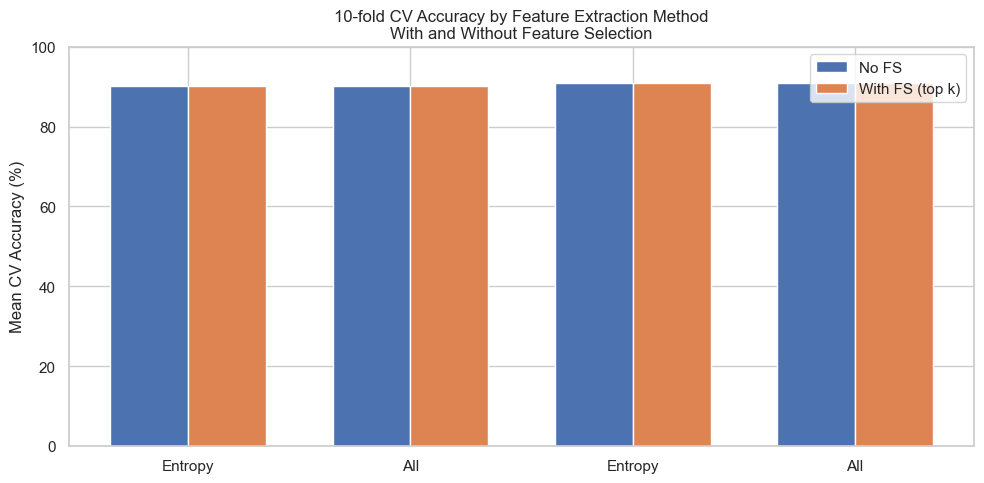

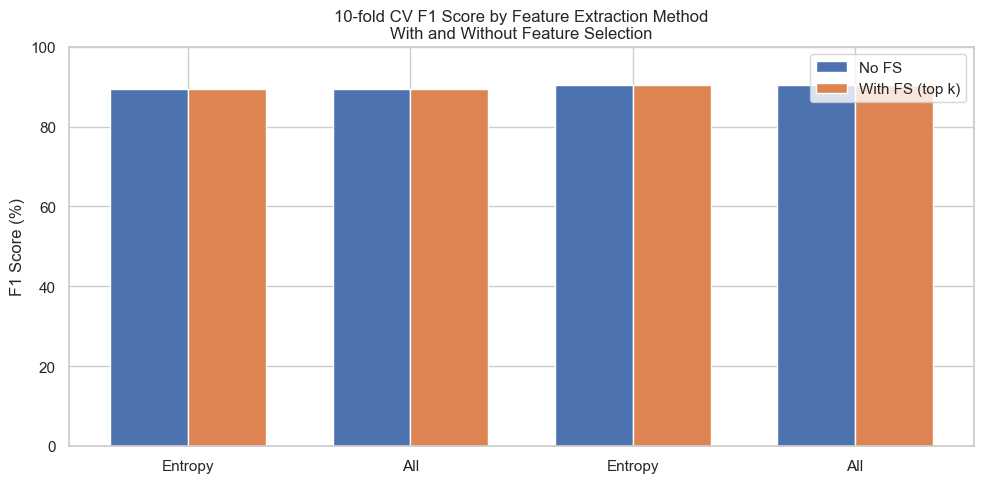

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values from summary_df
feature_labels = summary_df["Feature Vector"].tolist()
acc_nofs = summary_df["ACC"].tolist()
f1_nofs = summary_df["F1"].tolist()


acc_fs = summary_df.get("ACC (FS)", summary_df["ACC"]).tolist()
f1_fs = summary_df.get("F1 (FS)", summary_df["F1"]).tolist()

x = np.arange(len(feature_labels))
width = 0.35

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, acc_nofs, width, label='No FS')
plt.bar(x + width/2, acc_fs, width, label='With FS (top k)')
plt.xticks(x, feature_labels)
plt.ylabel('Mean CV Accuracy (%)')
plt.title('10-fold CV Accuracy by Feature Extraction Method\nWith and Without Feature Selection')
plt.ylim([0, 100])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# F1 Score Plot
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, f1_nofs, width, label='No FS')
plt.bar(x + width/2, f1_fs, width, label='With FS (top k)')
plt.xticks(x, feature_labels)
plt.ylabel('F1 Score (%)')
plt.title('10-fold CV F1 Score by Feature Extraction Method\nWith and Without Feature Selection')
plt.ylim([0, 100])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
